# In this business case:

## Try to analyze the data leading up to the Volkswagen buyout of Porsche. 

## Compare what models describe the stock best (before and after each announcement)


## Importing the Packages

In [1]:
import numpy as np
import pandas as pd
import scipy
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from pmdarima.arima import OCSBTest 
from statsmodels.tsa.arima_model import ARIMA
from arch import arch_model
import seaborn as sns
import yfinance
import warnings
warnings.filterwarnings("ignore")
sns.set()

## We can apply a "in retrospect" approach to see how time variant patterns change as new data is added. 

## **Importing the Data from yahoo finance**. 

### .DE indicates that the data was recorded from the german stock market. 

### The market benchmark will be the stocks from BMW. 

In [2]:
raw_data = yfinance.download (tickers = "VOW3.DE, PAH3.DE, BMW.DE", interval = "1d", group_by = 'ticker',
                              auto_adjust = True, treads = True)

[*********************100%***********************]  3 of 3 completed


In [3]:
df = raw_data.copy()

In [4]:
df.head()

PAH3.DE                       VOW3.DE                        \
              Open High Low Close Volume    Open High Low Close Volume   
Date                                                                     
1996-11-08     NaN  NaN NaN   NaN    NaN     NaN  NaN NaN   NaN    NaN   
1996-11-11     NaN  NaN NaN   NaN    NaN     NaN  NaN NaN   NaN    NaN   
1996-11-12     NaN  NaN NaN   NaN    NaN     NaN  NaN NaN   NaN    NaN   
1996-11-13     NaN  NaN NaN   NaN    NaN     NaN  NaN NaN   NaN    NaN   
1996-11-14     NaN  NaN NaN   NaN    NaN     NaN  NaN NaN   NaN    NaN   

               BMW.DE                                              
                 Open       High        Low      Close     Volume  
Date                                                               
1996-11-08  10.063325  10.063325  10.041773  10.041773   767000.0  
1996-11-11  10.052274  10.057801   9.992591  10.014695   260000.0  
1996-11-12  10.036247  10.128536   9.998116  10.090405  1066000.0  
1996-11-13  10.137377  10.137377  10.052273  10.074377   793000.0  
1996-11-14  10.060562  10.106982  10.020220  10.106982   351000.0

## Defining Key Dates

In [5]:
# Starting Date
start_date = "2009-04-05" 

# First Official Announcement - VW owns 49.9% of Porsche.  
ann_1 = "2009-12-09" 

# Second Official Announcement - 50.1% - VW owns all Porsche. 
ann_2 = "2012-07-05" 

#Ending Date
end_date = "2014-01-01"

# Dieselgate scandal. 
d_gate = '2015-09-20' 

## Pre-processing the Data

In [6]:
# Extracting Closing Prices
df['vol'] = df['VOW3.DE'].Close
df['por'] = df['PAH3.DE'].Close
df['bmw'] = df['BMW.DE'].Close

# Creating Returns
df['ret_vol'] = df['vol'].pct_change(1).mul(100)
df['ret_por'] = df['por'].pct_change(1).mul(100)
df['ret_bmw'] = df['bmw'].pct_change(1).mul(100)

# Creating Squared Returns
df['sq_vol'] = df.ret_vol.mul(df.ret_vol)
df['sq_por'] = df.ret_por.mul(df.ret_por)
df['sq_bmw'] = df.ret_bmw.mul(df.ret_bmw)

# Extracting Volume : number of purchases and sales each day. 
df['q_vol'] = df['VOW3.DE'].Volume
df['q_por'] = df['PAH3.DE'].Volume
df['q_bmw'] = df['BMW.DE'].Volume

In [7]:
df.head()

PAH3.DE                       VOW3.DE                        ...  \
              Open High Low Close Volume    Open High Low Close Volume  ...   
Date                                                                    ...   
1996-11-08     NaN  NaN NaN   NaN    NaN     NaN  NaN NaN   NaN    NaN  ...   
1996-11-11     NaN  NaN NaN   NaN    NaN     NaN  NaN NaN   NaN    NaN  ...   
1996-11-12     NaN  NaN NaN   NaN    NaN     NaN  NaN NaN   NaN    NaN  ...   
1996-11-13     NaN  NaN NaN   NaN    NaN     NaN  NaN NaN   NaN    NaN  ...   
1996-11-14     NaN  NaN NaN   NaN    NaN     NaN  NaN NaN   NaN    NaN  ...   

                  bmw ret_vol ret_por   ret_bmw sq_vol sq_por    sq_bmw q_vol  \
                                                                                
Date                                                                            
1996-11-08  10.041773     NaN     NaN       NaN    NaN    NaN       NaN   NaN   
1996-11-11  10.014695     NaN     NaN -0.269650    NaN    NaN  0.072711   NaN   
1996-11-12  10.090405     NaN     NaN  0.755992    NaN    NaN  0.571524   NaN   
1996-11-13  10.074377     NaN     NaN -0.158848    NaN    NaN  0.025233   NaN   
1996-11-14  10.106982     NaN     NaN  0.323645    NaN    NaN  0.104746   NaN   

           q_por      q_bmw  
                             
Date                         
1996-11-08   NaN   767000.0  
1996-11-11   NaN   260000.0  
1996-11-12   NaN  1066000.0  
1996-11-13   NaN   793000.0  
1996-11-14   NaN   351000.0  

[5 rows x 27 columns]

In [8]:
# Assigning the Frequency and Filling NA Values
df = df.asfreq('b') # bussiness days
df = df.fillna(method='bfill') # backfill 

In [9]:
# Removing Surplus Data: the entire tickets. 
del df['VOW3.DE']
del df['PAH3.DE']
del df['BMW.DE']

#### We usually split the data into a training and a testing set, but in this example we are examining a specific event in time, rather than trying to predict the future. 

## Plotting the Prices

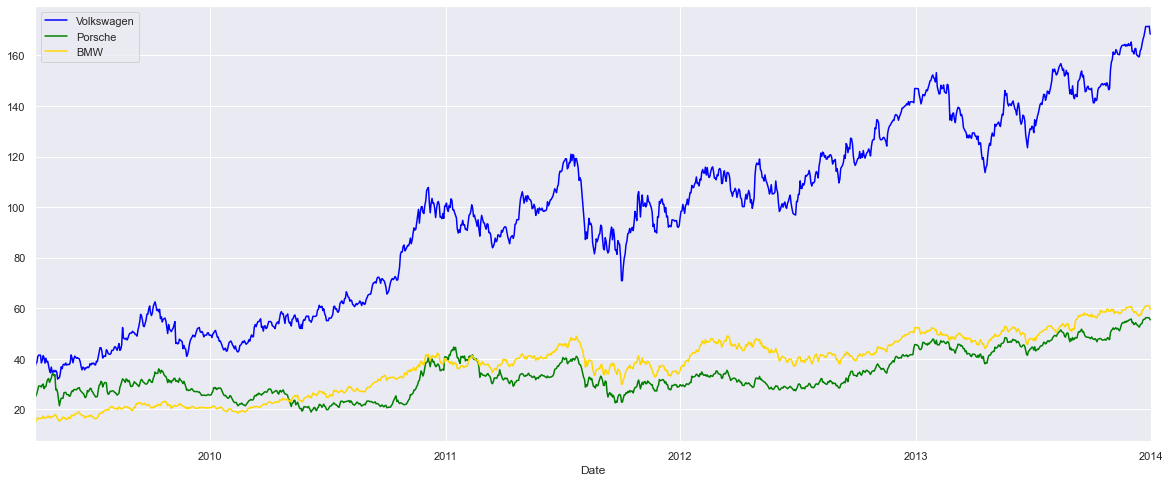

In [10]:
df['vol'][start_date:end_date].plot(figsize= (20,8), color = "blue")
df['por'][start_date:end_date].plot(color = "green")
df['bmw'][start_date:end_date].plot(color = "gold")
plt.legend(['Volkswagen','Porsche','BMW'])
plt.show()

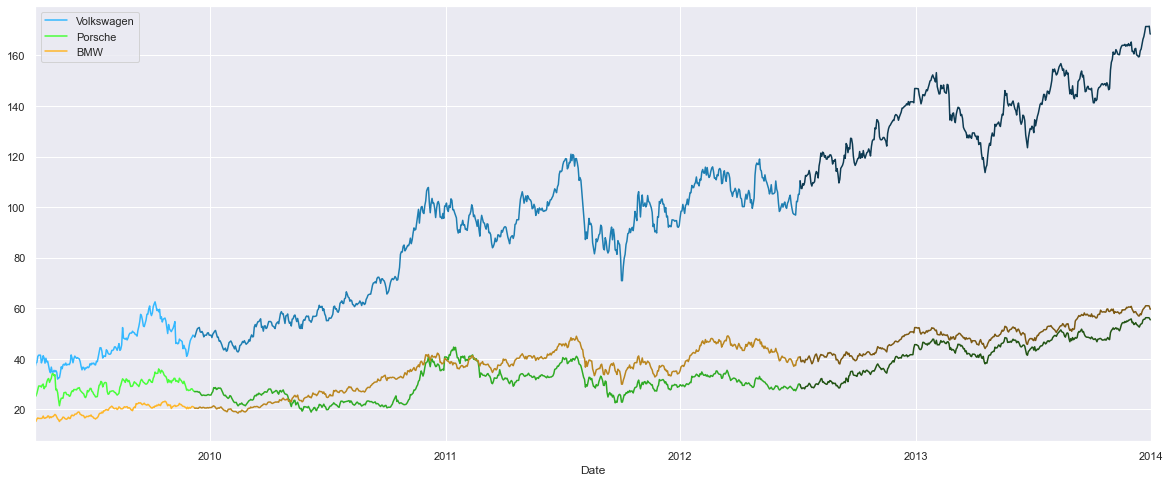

In [11]:
df['vol'][start_date:ann_1].plot(figsize= (20,8), color = "#33B8FF")
df['por'][start_date:ann_1].plot(color = "#49FF3A")
df['bmw'][start_date:ann_1].plot(color = "#FEB628")

df['vol'][ann_1:ann_2].plot(color = "#1E7EB2")
df['por'][ann_1:ann_2].plot(color = "#2FAB25")
df['bmw'][ann_1:ann_2].plot(color = "#BA861F")

df['vol'][ann_2:end_date].plot(color = "#0E3A52")
df['por'][ann_2:end_date].plot(color = "#225414")
df['bmw'][ann_2:end_date].plot(color = "#7C5913")

plt.legend(['Volkswagen','Porsche','BMW'])

plt.show()

## Correlation

### Corr(BMW, VW) = Corr(VW,BMW)

In [12]:
print('Correlation among manufacturers from ' + str(start_date) + ' to ' + str(end_date)+ '\n')
print('Volkswagen and Porsche correlation: \t'+ str(df['vol'][start_date:end_date].corr(df['por'][start_date:end_date])))
print('Volkswagen and BMW correlation: \t'+ str(df['vol'][start_date:end_date].corr(df['bmw'][start_date:end_date])))
print('Porsche and BMW correlation: \t\t'+ str(df['por'][start_date:end_date].corr(df['bmw'][start_date:end_date])))

Correlation among manufacturers from 2009-04-05 to 2014-01-01

Volkswagen and Porsche correlation: 	0.8359547136550096
Volkswagen and BMW correlation: 	0.9799378233575714
Porsche and BMW correlation: 		0.8052157942712348


## Correlation for the 3 different periods. 

In [13]:
print('Correlation among manufacturers from ' + str(start_date) + ' to ' + str(ann_1)+ '\n')
print('Volkswagen and Porsche correlation: \t'+ str(df['vol'][start_date:ann_1].corr(df['por'][start_date:ann_1])))
print('Volkswagen and BMW correlation: \t'+ str(df['vol'][start_date:ann_1].corr(df['bmw'][start_date:ann_1])))
print('Porsche and BMW correlation: \t\t'+ str(df['por'][start_date:ann_1].corr(df['bmw'][start_date:ann_1])))

Correlation among manufacturers from 2009-04-05 to 2009-12-09

Volkswagen and Porsche correlation: 	0.6633583864147119
Volkswagen and BMW correlation: 	0.842760794956949
Porsche and BMW correlation: 		0.6095037648215886


## The stock prices for Porsche and BMW weren't too similar before the start of the buyout. 

In [14]:
print('Correlation among manufacturers from ' + str(ann_1) + ' to ' + str(ann_2)+ '\n')
print('Volkswagen and Porsche correlation: \t'+ str(df['vol'][ann_1:ann_2].corr(df['por'][ann_1:ann_2])))
print('Volkswagen and BMW correlation: \t'+ str(df['vol'][ann_1:ann_2].corr(df['bmw'][ann_1:ann_2])))
print('Porsche and BMW correlation: \t\t'+ str(df['por'][ann_1:ann_2].corr(df['bmw'][ann_1:ann_2])))

Correlation among manufacturers from 2009-12-09 to 2012-07-05

Volkswagen and Porsche correlation: 	0.7428268327842665
Volkswagen and BMW correlation: 	0.979594301590077
Porsche and BMW correlation: 		0.7042723770300267


In [15]:
print('Correlation among manufacturers from ' + str(ann_2) + ' to ' + str(end_date)+ '\n')
print('Volkswagen and Porsche correlation: \t'+ str(df['vol'][ann_2:end_date].corr(df['por'][ann_2:end_date])))
print('Volkswagen and BMW correlation: \t'+ str(df['vol'][ann_2:end_date].corr(df['bmw'][ann_2:end_date])))
print('Porsche and BMW correlation: \t\t'+ str(df['por'][ann_2:end_date].corr(df['bmw'][ann_2:end_date])))

Correlation among manufacturers from 2012-07-05 to 2014-01-01

Volkswagen and Porsche correlation: 	0.940523727943161
Volkswagen and BMW correlation: 	0.928444737413633
Porsche and BMW correlation: 		0.9494111675956787


## When VW buy Porsche shares completely the correlation is the greater.

In [16]:
print('Correlation among manufacturers from ' + str(end_date) + ' to ' + str(df.index[-1])+ '\n')
print('Volkswagen and Porsche correlation: \t'+ str(df['vol'][end_date:].corr(df['por'][end_date:])))
print('Volkswagen and BMW correlation: \t'+ str(df['vol'][end_date:].corr(df['bmw'][end_date:])))
print('Porsche and BMW correlation: \t\t'+ str(df['por'][end_date:].corr(df['bmw'][end_date:])))

Correlation among manufacturers from 2014-01-01 to 2021-11-05 00:00:00

Volkswagen and Porsche correlation: 	0.949558221517536
Volkswagen and BMW correlation: 	0.6960925907067795
Porsche and BMW correlation: 		0.717817963819933


# **Best Fitting Models**

### For Volkswagen

In [17]:
mod_pr_pre_vol = auto_arima(df.vol[start_date:ann_1], exogenous = df[['por','bmw']][start_date:ann_1],
                            m = 5, max_p = 5, max_q = 5)
mod_pr_btn_vol = auto_arima(df.vol[ann_1:ann_2], exogenous = df[['por','bmw']][ann_1:ann_2],
                            m = 5, max_p = 5, max_q = 5)
mod_pr_post_vol = auto_arima(df.vol[ann_2:end_date], exogenous = df[['por','bmw']][ann_2:end_date],
                            m = 5, max_p = 5, max_q = 5)

In [18]:
mod_pr_pre_vol.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  178
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -322.988
Date:                Fri, 05 Nov 2021   AIC                            655.976
Time:                        14:32:45   BIC                            671.885
Sample:                    04-06-2009   HQIC                           662.427
                         - 12-09-2009                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.7232      0.447      1.618      0.106      -0.153       1.599
por            0.4000      0.096      4.168      0.000       0.212       0.588
bmw            0.6919      0.328      2.107      0.035       0.048       1.335
ar.L1          0.9633      0.020     48.670      0.000       0.925       1.002
sigma2         2.1737      0.148     14.718      0.000       1.884       2.463
===================================================================================
Ljung-Box (L1) (Q):                   0.77   Jarque-Bera (JB):               166.03
Prob(Q):                              0.38   Prob(JB):                         0.00
Heteroskedasticity (H):               1.61   Skew:                            -0.52
Prob(H) (two-sided):                  0.07   Kurtosis:                         7.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## ARIMAX (1,1,1)

In [19]:
mod_pr_btn_vol.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  672
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1080.051
Date:                Fri, 05 Nov 2021   AIC                           2166.102
Time:                        14:32:45   BIC                           2179.628
Sample:                    12-09-2009   HQIC                          2171.341
                         - 07-05-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
por            0.7908      0.062     12.842      0.000       0.670       0.912
bmw            1.5487      0.073     21.268      0.000       1.406       1.691
sigma2         1.4643      0.060     24.532      0.000       1.347       1.581
===================================================================================
Ljung-Box (L1) (Q):                   2.07   Jarque-Bera (JB):               112.41
Prob(Q):                              0.15   Prob(JB):                         0.00
Heteroskedasticity (H):               1.65   Skew:                             0.29
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [20]:
mod_pr_post_vol.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  390
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -607.774
Date:                Fri, 05 Nov 2021   AIC                           1221.548
Time:                        14:32:45   BIC                           1233.438
Sample:                    07-05-2012   HQIC                          1226.262
                         - 01-01-2014                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
por            1.7190      0.057     30.369      0.000       1.608       1.830
bmw            0.8575      0.091      9.381      0.000       0.678       1.037
sigma2         1.3323      0.065     20.461      0.000       1.205       1.460
===================================================================================
Ljung-Box (L1) (Q):                   0.23   Jarque-Bera (JB):               103.80
Prob(Q):                              0.63   Prob(JB):                         0.00
Heteroskedasticity (H):               0.78   Skew:                            -0.39
Prob(H) (two-sided):                  0.15   Kurtosis:                         5.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### For Porsche

In [21]:
mod_pr_pre_por = auto_arima(df.por[start_date:ann_1], exogenous = df[['vol','bmw']][start_date:ann_1],
                            m = 5, max_p = 5, max_q = 5)
mod_pr_btn_por = auto_arima(df.por[ann_1:ann_2], exogenous = df[['vol','bmw']][ann_1:ann_2],
                            m = 5, max_p = 5, max_q = 5)
mod_pr_post_por = auto_arima(df.por[ann_2:end_date], exogenous = df[['vol','bmw']][ann_2:end_date],
                             m = 5, max_p = 5, max_q = 5)

## AR(2)

In [22]:
mod_pr_pre_por.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  178
Model:               SARIMAX(2, 0, 0)   Log Likelihood                -225.800
Date:                Fri, 05 Nov 2021   AIC                            463.601
Time:                        14:33:22   BIC                            482.692
Sample:                    04-06-2009   HQIC                           471.343
                         - 12-09-2009                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.5755      0.375      1.533      0.125      -0.160       1.311
vol            0.1150      0.053      2.157      0.031       0.011       0.219
bmw            0.8819      0.159      5.558      0.000       0.571       1.193
ar.L1          1.0748      0.059     18.194      0.000       0.959       1.191
ar.L2         -0.1589      0.059     -2.716      0.007      -0.274      -0.044
sigma2         0.7319      0.052     14.098      0.000       0.630       0.834
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               559.40
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.21   Skew:                            -0.96
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## ARIMA(1,1,0)

In [23]:
mod_pr_btn_por.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  672
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -580.933
Date:                Fri, 05 Nov 2021   AIC                           1171.866
Time:                        14:33:22   BIC                           1194.410
Sample:                    12-09-2009   HQIC                          1180.598
                         - 07-05-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
vol            0.1785      0.016     11.134      0.000       0.147       0.210
bmw            0.3317      0.046      7.200      0.000       0.241       0.422
ar.L1          0.6585      0.230      2.860      0.004       0.207       1.110
ma.L1         -0.5898      0.246     -2.394      0.017      -1.073      -0.107
sigma2         0.3308      0.010     32.415      0.000       0.311       0.351
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1076.51
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               1.39   Skew:                             0.05
Prob(H) (two-sided):                  0.01   Kurtosis:                         9.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## SARIMAX(0,1,0)X(0,0,1,5)

## These trends are affected more by current events rather than pre-existing patterns. 

In [24]:
mod_pr_post_por.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  390
Model:             SARIMAX(0, 1, 0)x(0, 0, [1], 5)   Log Likelihood                -210.239
Date:                             Fri, 05 Nov 2021   AIC                            428.477
Time:                                     14:33:22   BIC                            444.332
Sample:                                 07-05-2012   HQIC                           434.763
                                      - 01-01-2014                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
vol            0.2219      0.013     16.876      0.000       0.196       0.248
bmw            0.2504      0.041      6.036      0.000       0.169       0.332
ma.S.L5       -0.1249      0.057     -2.210      0.027      -0.236      -0.014
sigma2         0.1725      0.006     27.851      0.000       0.160       0.185
===================================================================================
Ljung-Box (L1) (Q):                   2.09   Jarque-Bera (JB):               613.59
Prob(Q):                              0.15   Prob(JB):                         0.00
Heteroskedasticity (H):               0.57   Skew:                             0.88
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Predictions for the Future

### For Porsche

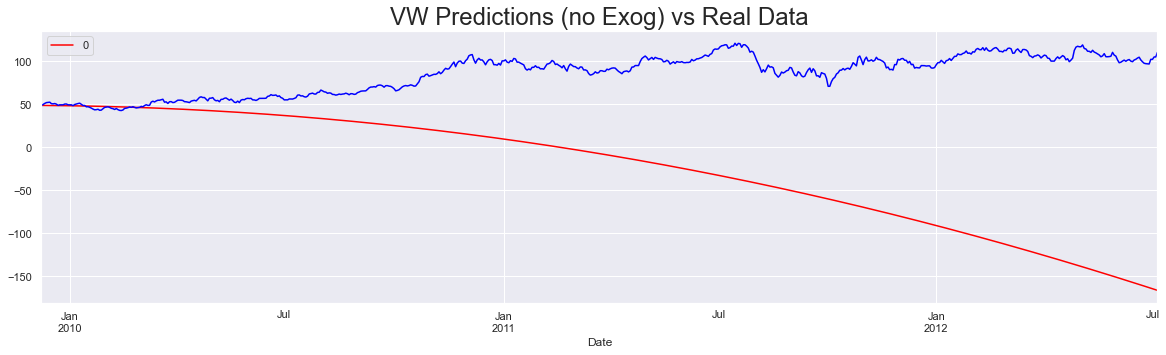

In [25]:
model_auto_pred_pr = auto_arima(df.vol[start_date:ann_1], m = 5, max_p = 5, max_q = 5, max_P = 5, max_Q = 5, trend = "ct")

df_auto_pred_pr = pd.DataFrame(model_auto_pred_pr.predict(n_periods = len(df[ann_1:ann_2])), index = df[ann_1:ann_2].index)
df_auto_pred_pr[ann_1:ann_2].plot(figsize = (20,5), color = "red")

df.vol[ann_1:ann_2].plot(color = "blue")
plt.title("VW Predictions (no Exog) vs Real Data", size = 24)
plt.show()

## The predictions are good for the first 3 or 4 months but dropout drastically. 

## The announcement didnt make a great shift in price trends for VW initially. This can be attributed to the market lags  where new information as well as new policies take a while to respond. 

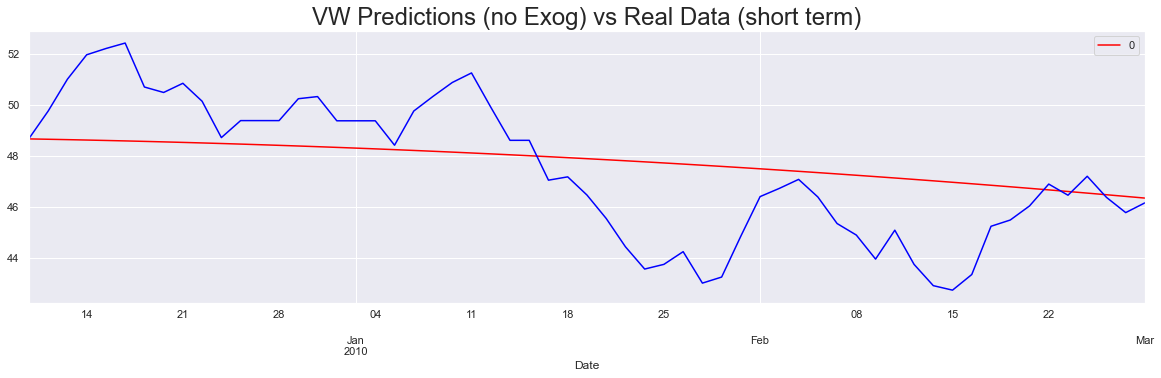

In [26]:
df_auto_pred_pr[ann_1:'2010-03-01'].plot(figsize = (20,5), color = "red")
df.vol[ann_1:'2010-03-01'].plot(color = "blue")
plt.title("VW Predictions (no Exog) vs Real Data (short term)", size = 24)
plt.show()

### For Volkswagen

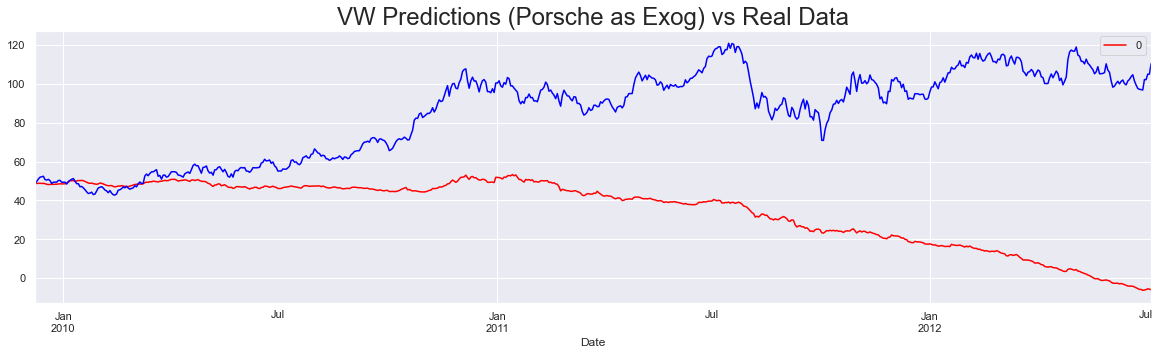

In [27]:
model_auto_pred_pr = auto_arima(df.vol[start_date:ann_1], exogenous = df[['por']][start_date:ann_1],
                          m = 5, max_p = 5, max_q = 5, max_P = 5, max_Q = 5, trend = "ct")

df_auto_pred_pr = pd.DataFrame(model_auto_pred_pr.predict(n_periods = len(df[ann_1:ann_2]), exogenous = df[['por']][ann_1:ann_2]),
                               index = df[ann_1:ann_2].index)
df_auto_pred_pr[ann_1:ann_2].plot(figsize = (20,5), color = "red")

df.vol[ann_1:ann_2].plot(color = "blue")
plt.title("VW Predictions (Porsche as Exog) vs Real Data", size = 24)
plt.show()

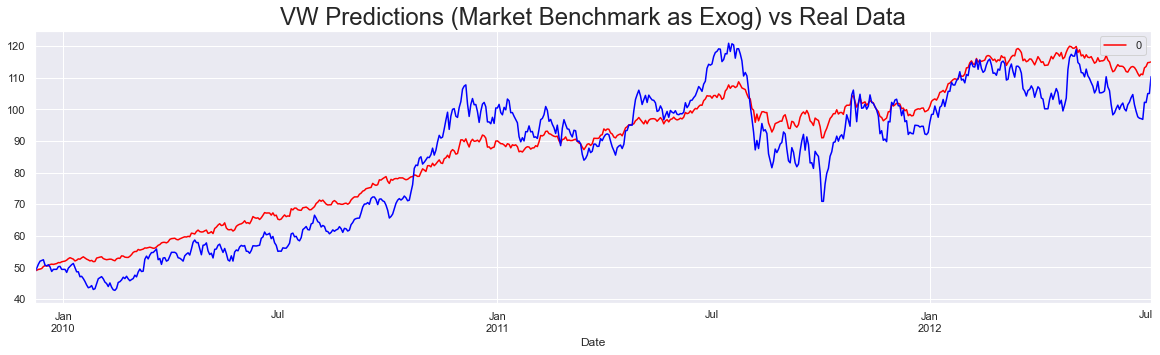

In [28]:
model_auto_pred_pr = auto_arima(df.vol[start_date:ann_1], exogenous = df[['bmw']][start_date:ann_1],
                          m = 5, max_p = 5, max_q = 5, max_P = 5, max_Q = 5, trend = "ct")

df_auto_pred_pr = pd.DataFrame(model_auto_pred_pr.predict(n_periods = len(df[ann_1:ann_2]), exogenous = df[['bmw']][ann_1:ann_2]),
                               index = df[ann_1:ann_2].index)
df_auto_pred_pr[ann_1:ann_2].plot(figsize = (20,5), color = "red")

df.vol[ann_1:ann_2].plot(color = "blue")
plt.title("VW Predictions (Market Benchmark as Exog) vs Real Data", size = 24)
plt.show()

## The model doesnt adjust to jumps and downs as fast as expected, it doesn't capture its magnitude. 

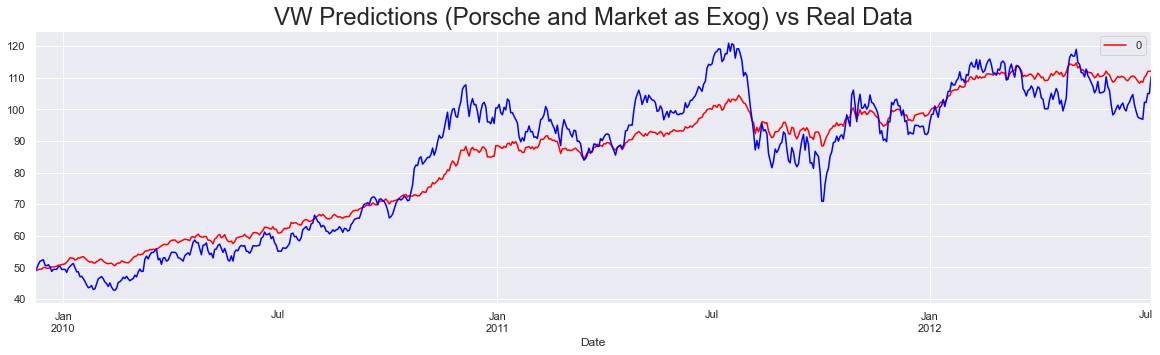

In [29]:
model_auto_pred_pr = auto_arima(df.vol[start_date:ann_1], exogenous = df[['por', 'bmw']][start_date:ann_1],
                          m = 5, max_p = 5, max_q = 5, max_P = 5, max_Q = 5, trend = "ct")

df_auto_pred_pr = pd.DataFrame(model_auto_pred_pr.predict(n_periods = len(df[ann_1:ann_2]), exogenous = df[['por','bmw']][ann_1:ann_2]),
                               index = df[ann_1:ann_2].index)
df_auto_pred_pr[ann_1:ann_2].plot(figsize = (20,5), color = "red")

df.vol[ann_1:ann_2].plot(color = "blue")
plt.title("VW Predictions (Porsche and Market as Exog) vs Real Data", size = 24)
plt.show()

## This model mathces the smaller shifts better. 

## MAX models are less affected by real-life events 

# **Volatility**

### Volatility of VW for Each Period

## Rumors and speculations fuel market trade. 

## Squared returns represents the volatility of a stock. 

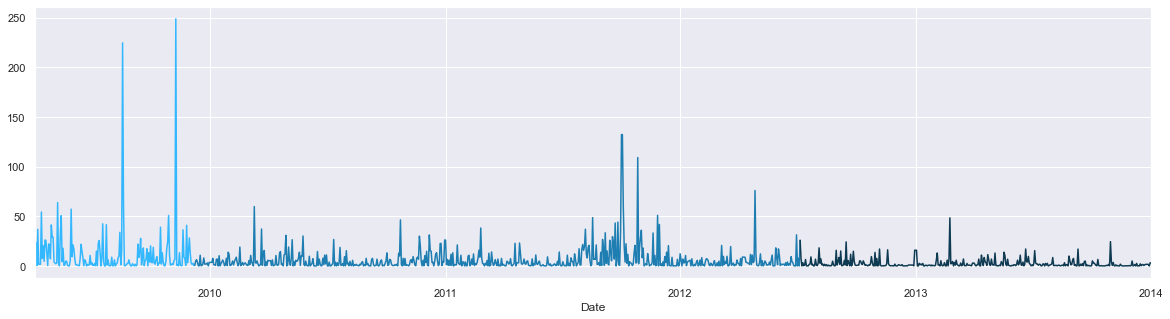

In [30]:
df['sq_vol'][start_date:ann_1].plot(figsize = (20,5), color = "#33B8FF")
df['sq_vol'][ann_1:ann_2].plot(color = "#1E7EB2")
df['sq_vol'][ann_2:end_date].plot(color = "#0E3A52")
plt.show()

## Before any of the announcements, VW exhibits the highest volatility. The stock became stable after the two announcemets.  And it becames innestable when the rumors of the total purchase is in the air. 

### Volatility Trends for Each Period

In [31]:
model_garch_pre = arch_model(df.ret_vol[start_date:ann_1], mean = "Constant",  vol = "GARCH", p = 1, q = 1)
results_garch_pre = model_garch_pre.fit(update_freq = 5)

model_garch_btn = arch_model(df.ret_vol[ann_1:ann_2], mean = "Constant",  vol = "GARCH", p = 1, q = 1)
results_garch_btn = model_garch_btn.fit(update_freq = 5)

model_garch_post = arch_model(df.ret_vol[ann_2:end_date], mean = "Constant",  vol = "GARCH", p = 1, q = 1)
results_garch_post = model_garch_post.fit(update_freq = 5)

Iteration:      5,   Func. Count:     31,   Neg. LLF: 475.77744629561573
Iteration:     10,   Func. Count:     56,   Neg. LLF: 475.00306203371844
Iteration:     15,   Func. Count:     80,   Neg. LLF: 474.990414529513
Optimization terminated successfully    (Exit mode 0)
            Current function value: 474.99041447722084
            Iterations: 15
            Function evaluations: 80
            Gradient evaluations: 15
Iteration:      5,   Func. Count:     38,   Neg. LLF: 1526.7533962458433
Iteration:     10,   Func. Count:     62,   Neg. LLF: 1526.731465375387
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1526.7314653741423
            Iterations: 10
            Function evaluations: 62
            Gradient evaluations: 10
Iteration:      5,   Func. Count:     34,   Neg. LLF: 724.5623000603607
Optimization terminated successfully    (Exit mode 0)
            Current function value: 724.5579458751608
            Iterations: 7
            

In [32]:
results_garch_pre.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                ret_vol   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -474.990
Distribution:                  Normal   AIC:                           957.981
Method:            Maximum Likelihood   BIC:                           970.708
                                        No. Observations:                  178
Date:                Fri, Nov 05 2021   Df Residuals:                      177
Time:                        14:33:42   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.1570      0.266      0.589      0.556 [ -0.365,  0.679]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega         10.6196      4.227      2.512  1.200e-02    [  2.334, 18.905]
alpha[1]       0.1540  9.194e-02      1.675  9.399e-02 [-2.623e-02,  0.334]
beta[1]    1.6015e-13      0.349  4.586e-13      1.000    [ -0.684,  0.684]
===========================================================================

Covariance estimator: robust
"""

## P value of 1 for beta 1 the trends in variance are not as persisted as we expected. So we dont need a GARCH component. 

In [33]:
results_garch_btn.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                ret_vol   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1526.73
Distribution:                  Normal   AIC:                           3061.46
Method:            Maximum Likelihood   BIC:                           3079.50
                                        No. Observations:                  672
Date:                Fri, Nov 05 2021   Df Residuals:                      671
Time:                        14:33:42   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1892  8.634e-02      2.191  2.843e-02 [1.998e-02,  0.358]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.1679  7.914e-02      2.122  3.388e-02 [1.279e-02,  0.323]
alpha[1]       0.0688  1.682e-02      4.091  4.301e-05 [3.585e-02,  0.102]
beta[1]        0.9040  2.108e-02     42.883      0.000   [  0.863,  0.945]
==========================================================================

Covariance estimator: robust
"""

## P value of beta1 = 0. The autocorrelation in the  conditional variance is significant and hardly dies off based on the coefficient. 

## The coeffiecient of mu for the mean model states that there is some constant trend in the return values. 

## **We never expect returns or their volatility to ever be perfectly stable**

In [34]:
results_garch_post.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                ret_vol   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -724.558
Distribution:                  Normal   AIC:                           1457.12
Method:            Maximum Likelihood   BIC:                           1472.98
                                        No. Observations:                  390
Date:                Fri, Nov 05 2021   Df Residuals:                      389
Time:                        14:33:42   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.2298  9.845e-02      2.334  1.958e-02 [3.685e-02,  0.423]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.7719      0.677      1.141      0.254    [ -0.555,  2.098]
alpha[1]       0.1853      0.145      1.273      0.203 [-9.991e-02,  0.470]
beta[1]        0.5136      0.331      1.550      0.121    [ -0.136,  1.163]
===========================================================================

Covariance estimator: robust
"""